<a href="https://colab.research.google.com/github/datamino/PINNs/blob/main/case2_p1_(LOHS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0/5000, Loss: 191.48468017578125
Epoch 1000/5000, Loss: 0.8308907151222229
Epoch 2000/5000, Loss: 0.029263662174344063
Epoch 3000/5000, Loss: 0.006871671881526709
Epoch 4000/5000, Loss: 0.0030977362766861916


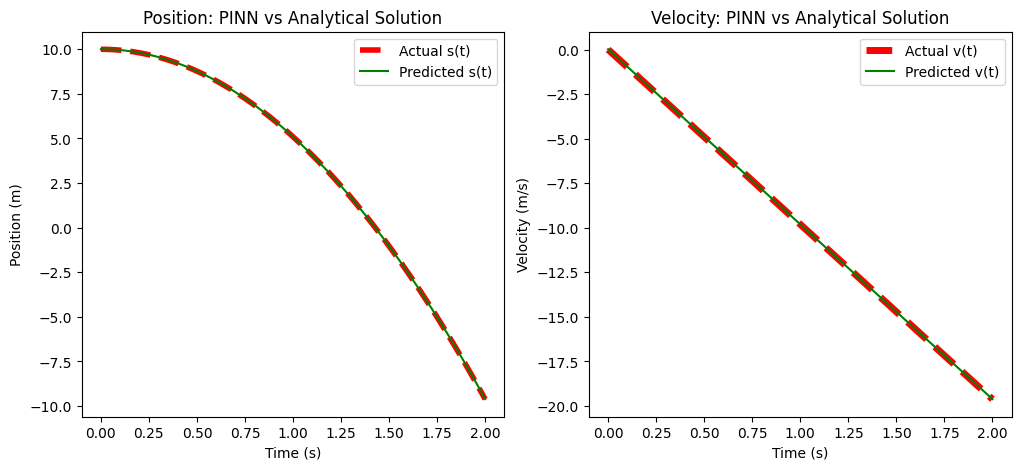

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# ✅ Given parameters
g = 9.81  # Gravity (m/s^2)
s0 = 10.0  # Initial position (m)
v0 = 0.0   # Initial velocity (m/s)

# ✅ Analytical (True) Solutions
def true_solution(t):
    s_true = s0 + v0 * t - 0.5 * g * t**2   # Position
    v_true = v0 - g * t                     # Velocity
    return s_true, v_true

# ✅ Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 5), nn.Tanh(),
            nn.Linear(5, 5), nn.Tanh(),
            nn.Linear(5, 2)  # 🔹 Output two values: [s(t), v(t)]
        )

    def forward(self, t):
        output = self.layers(t)
        s, v = output[:, 0:1], output[:, 1:2]  # Separate outputs
        return s, v

# ✅ Define the loss function based on the governing equations
def loss(model, t):
    t.requires_grad = True
    s, v = model(t)  # 🔹 Get outputs

    # Compute derivatives using autograd
    ds_dt = torch.autograd.grad(s, t, torch.ones_like(s), create_graph=True)[0]
    dv_dt = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]

    # Physics-based loss
    eq1_loss = torch.mean((ds_dt - v) ** 2)  # ds/dt = v
    eq2_loss = torch.mean((dv_dt + g) ** 2)  # dv/dt = -g

    # Initial conditions loss
    s_pred, v_pred = model(torch.tensor([[0.0]]))  # Predict at t=0
    ic_loss = torch.mean((s_pred - s0) ** 2) + torch.mean((v_pred - v0) ** 2)

    return eq1_loss + eq2_loss + ic_loss

# ✅ Training the neural network
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

t_train = torch.linspace(0, 2, 100).view(-1, 1)  # Training points from 0 to 2 sec

loss_history = []
for epoch in range(5000):
    optimizer.zero_grad()
    loss_value = loss(model, t_train)
    loss_value.backward()
    optimizer.step()
    loss_history.append(loss_value.item())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/5000, Loss: {loss_value.item()}")

# ✅ Compare PINN Predictions with Analytical Solution
t_test = torch.linspace(0, 2, 100).view(-1, 1)

# Compute Analytical Solution
s_actual, v_actual = true_solution(t_test.numpy())  # Convert t_test to numpy for true solution

# Compute PINN Predictions
s_pred, v_pred = model(t_test)
s_pred = s_pred.detach().numpy()
v_pred = v_pred.detach().numpy()

# ✅ Plot results
plt.figure(figsize=(12, 5))

# Plot Position
plt.subplot(1, 2, 1)
plt.plot(t_test.numpy(), s_actual, label="Actual s(t)", linestyle="dashed", color="red" ,linewidth=4)
plt.plot(t_test.numpy(), s_pred, label="Predicted s(t)", linestyle="solid", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Position: PINN vs Analytical Solution")

# Plot Velocity
plt.subplot(1, 2, 2)
plt.plot(t_test.numpy(), v_actual, label="Actual v(t)", linestyle="dashed", color="red", linewidth=5)
plt.plot(t_test.numpy(), v_pred, label="Predicted v(t)", linestyle="solid", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Velocity: PINN vs Analytical Solution")

plt.show()
